In [2]:
import networkx as nx
import pandas as pd
import pprint
from gurobipy import *
import matplotlib.pyplot as plt
m = Model()

Restricted license - for non-production use only - expires 2023-10-25


In [3]:
I = list(range(1,26)) 
J = list(range(1,26))
K = list(range(1,26))

# Question 1.Kidney Exchange Optimization

## Step 1: Import Data

In [4]:
kpd = pd.read_csv("KPD_pool.csv")
print(kpd)

    Pair PatientBloodType  PatientTissueType DonorBloodType  DonorTissueType
0      1                A                  3             AB                4
1      2               AB                  4              B                2
2      3                A                  4             AB                1
3      4                A                  4              B                2
4      5                O                  2              A                1
5      6                A                  4              A                2
6      7                B                  4              A                1
7      8                A                  3             AB                3
8      9                A                  3              B                2
9     10                A                  1              B                1
10    11                O                  1              O                4
11    12                B                  2              A                2

## Step 2: Create matrix for donor-patient pairs

In [5]:
# create a dictionary to help determin blood type match between donors and patients
match = {"OO":1,"OA":1,"OB":1,"OAB":1,"AA":1,"AB":0,"AAB":1,"AO":0,"BB":1,"BA":0,"BAB":1,"BO":0,"ABAB":1,"ABA":0,"ABB":0,"ABO":0}

In [6]:
# create a dictionary to contain patients information
patient_blood_type = kpd["PatientBloodType"].tolist()
patient_tissue_type = kpd["PatientTissueType"].tolist()
patient = {}
for i in I:
    patient[i]=[patient_blood_type[i-1],patient_tissue_type[i-1]]
print(patient)

{1: ['A', 3], 2: ['AB', 4], 3: ['A', 4], 4: ['A', 4], 5: ['O', 2], 6: ['A', 4], 7: ['B', 4], 8: ['A', 3], 9: ['A', 3], 10: ['A', 1], 11: ['O', 1], 12: ['B', 2], 13: ['B', 1], 14: ['A', 2], 15: ['B', 2], 16: ['B', 1], 17: ['AB', 3], 18: ['O', 3], 19: ['O', 4], 20: ['A', 3], 21: ['A', 1], 22: ['B', 2], 23: ['AB', 3], 24: ['O', 4], 25: ['O', 5]}


In [7]:
# create a dictionary to contain donor information
donor_blood_type = kpd["DonorBloodType"].tolist()
donor_tissue_type = kpd["DonorTissueType"].tolist()
donor = {}
for i in I:
    donor[i]=[donor_blood_type[i-1],donor_tissue_type[i-1]]
print(donor)

{1: ['AB', 4], 2: ['B', 2], 3: ['AB', 1], 4: ['B', 2], 5: ['A', 1], 6: ['A', 2], 7: ['A', 1], 8: ['AB', 3], 9: ['B', 2], 10: ['B', 1], 11: ['O', 4], 12: ['A', 2], 13: ['AB', 2], 14: ['A', 4], 15: ['B', 4], 16: ['AB', 3], 17: ['A', 1], 18: ['B', 1], 19: ['AB', 3], 20: ['O', 1], 21: ['B', 5], 22: ['A', 4], 23: ['O', 3], 24: ['A', 2], 25: ['A', 1]}


In [8]:
# create a donor-patient matrix to contain all the possible donation between donors and patients 
# matrix[i][j]=1 means donation from donor i to patient j is feasible
# matrix[i][j]=0 means donation from donor i to patient j is not feasible
matrix = [[0]*len(I) for j in J]
for i in I:
    for j in J:
        if donor[i][1]==patient[j][1] and match[str(donor[i][0])+str(patient[j][0])] == 1:
            matrix[i-1][j-1] = 1
        else:
            matrix[i-1][j-1] = 0
print(matrix)

[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Step 3: Draw the pairs diagram

In [9]:
G = nx.DiGraph()
G.add_nodes_from(I)

In [10]:
elist = []
for i in I:
    for j in J:
        if matrix[i-1][j-1] == 1:
            elist.append((i,j))
print(elist)

[(1, 2), (2, 12), (2, 15), (2, 22), (4, 12), (4, 15), (4, 22), (5, 10), (5, 21), (6, 14), (7, 10), (7, 21), (8, 17), (8, 23), (9, 12), (9, 15), (9, 22), (10, 13), (10, 16), (11, 2), (11, 3), (11, 4), (11, 6), (11, 7), (11, 19), (11, 24), (12, 14), (14, 2), (14, 3), (14, 4), (14, 6), (15, 2), (15, 7), (16, 17), (16, 23), (17, 10), (17, 21), (18, 13), (18, 16), (19, 17), (19, 23), (20, 10), (20, 11), (20, 13), (20, 16), (20, 21), (22, 2), (22, 3), (22, 4), (22, 6), (23, 1), (23, 8), (23, 9), (23, 17), (23, 18), (23, 20), (23, 23), (24, 14), (25, 10), (25, 21)]


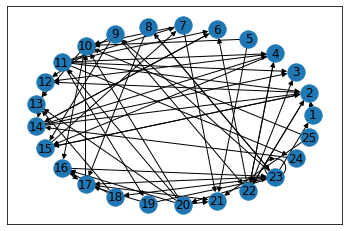

In [11]:
G.add_edges_from(elist)
nx.draw_networkx(G,
                pos = nx.circular_layout(G))

## Step 4: Add decision variables

In [12]:
x = m.addVars(I, J, vtype=GRB.BINARY,name="x")

## Step 5: Set objective function

In [13]:
m.setObjective(sum(x[i, j] for i in I for j in J),
                   GRB.MAXIMIZE)

## Step 6: Add constraints

### Constraint 1: Net flow equal to 0 for each node

In [14]:
for k in K:
    m.addConstr(sum(x[i,j]for i in I for j in J if j == k)-sum(x[i,j]for i in I for j in J if i == k) == 0)

### Constraint 2: Inflow equal to or less than 1 for each node

In [15]:
for k in K:
    m.addConstr(sum(x[i,j]for i in I for j in J if j == k) <= 1)

### Constraint 3: Outflow equal to or less than 1 for each node

In [16]:
for k in K:
    m.addConstr(sum(x[i,j]for i in I for j in J if i == k) <= 1)

### Constraint 4: Route constraints

In [17]:
# some donations between donor i and patient j is not feasible, therefore we have to set related x[i,j] to 0
m.addConstrs(x[i,j]==0 for i in I for j in J if matrix[i-1][j-1] == 0)

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (1, 17): <gurobi.Constr *Awaiting Model Update*>,
 (1, 18): <gurobi.Constr *Awaiting Model Update*>,
 (1, 19): <gurobi.Constr *Awaiting Model Update*>,
 (1, 20): <gurobi.Constr *Awaiting Model Update*>,
 (1, 21): <gurobi.Constr *Awaiting Mode

In [18]:
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 640 rows, 625 columns and 3015 nonzeros
Model fingerprint: 0x8d0bf25d
Variable types: 0 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 617 rows and 594 columns
Presolve time: 0.00s
Presolved: 23 rows, 31 columns, 108 nonzeros
Found heuristic solution: objective 11.0000000
Variable types: 0 continuous, 31 integer (31 binary)

Root relaxation: objective 1.300000e+01, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      13.0000000   13.00000  0.00%    

In [19]:
m.printAttr('X')


    Variable            X 
-------------------------
     x[2,15]            1 
     x[4,22]            1 
     x[6,14]            1 
    x[10,16]            1 
    x[11,19]            1 
     x[14,6]            1 
     x[15,2]            1 
    x[16,17]            1 
    x[17,10]            1 
    x[19,23]            1 
    x[20,11]            1 
     x[22,4]            1 
    x[23,20]            1 


## Step 7: Draw the final diagram after optimization

In [20]:
elist1 = []
for i in I:
    for j in J:
        if str(x[i,j]) == str("<gurobi.Var x[{},{}] (value 1.0)>".format(i,j)):
            elist1.append((i,j))
print(elist1)

[(2, 15), (4, 22), (6, 14), (10, 16), (11, 19), (14, 6), (15, 2), (16, 17), (17, 10), (19, 23), (20, 11), (22, 4), (23, 20)]


In [21]:
elist2=[item for item in elist if item not in elist1]
print(elist2)

[(1, 2), (2, 12), (2, 22), (4, 12), (4, 15), (5, 10), (5, 21), (7, 10), (7, 21), (8, 17), (8, 23), (9, 12), (9, 15), (9, 22), (10, 13), (11, 2), (11, 3), (11, 4), (11, 6), (11, 7), (11, 24), (12, 14), (14, 2), (14, 3), (14, 4), (15, 7), (16, 23), (17, 21), (18, 13), (18, 16), (19, 17), (20, 10), (20, 13), (20, 16), (20, 21), (22, 2), (22, 3), (22, 6), (23, 1), (23, 8), (23, 9), (23, 17), (23, 18), (23, 23), (24, 14), (25, 10), (25, 21)]


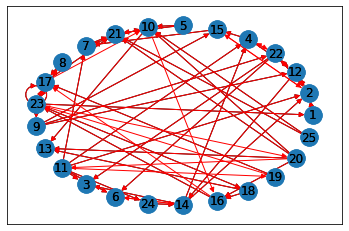

In [42]:
H = nx.DiGraph()
H.add_edges_from(elist2)
nx.draw_networkx(H,
                pos = nx.circular_layout(H),edge_color="k")
H.add_edges_from(elist1)
nx.draw_networkx(H,
                pos = nx.circular_layout(H),edge_color="r")

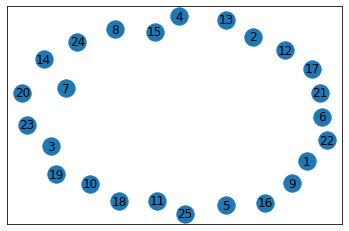

In [93]:
elist3=[elist1,elist2]
lst1=[]
lst2=[]
for edge in elist3:
    H = nx.DiGraph()
    H.add_nodes_from(I)
    if edge in elist3[0]:
        lst1.append(edge)
        H.add_edges_from(lst1)
        nx.draw_networkx(H,
                 pos = nx.circular_layout(H),
                edge_color="r")
    elif edge in elist3[1]:
        lst2.append(edge)
        H.add_edges_from(lst2)
        nx.draw_networkx(H,
                 pos = nx.circular_layout(H),
                edge_color="k")
nx.draw_networkx(H)

In [70]:
H = nx.DiGraph()
H.add_nodes_from(I)
H.add_edge(1,2)

# Question 2. Multi-Period Production Planning

In [102]:
import pandas as pd
from gurobipy import *
import openpyxl

In [103]:
# reading the inputs from Excel workbook
wb = openpyxl.load_workbook("inputs.xlsx")
main = wb['Main']

In [104]:
# read objevtive
obj = main.cell(column=2, row=1).value
if obj =='max':
    obj = -1
elif obj =='min':
    obj = 1
else:
    raise NameError('Objective cannot be recognized')
# read obj coefficient
obj_coeff = []
for c in range(2,10000):
    v = main.cell(column=c, row=3).value
    if v is None:
        break
    else:
        obj_coeff.append(v)
n_variables = len(obj_coeff)

#read variable properties
variable_name = []
for c in range(n_variables):
    v = main.cell(column=c+2, row=2).value
    if v is None:
        variable_name.append('x'+str(c+1))
    elif type(v) != str:
        variable_name.append(str(v))
    else:
        variable_name.append(v)
        
variable_type = []
for c in range(n_variables):
    v = main.cell(column=c+2, row=4).value
    if v is None:
        t = 'C' 
    elif v == 'cont':
        t = 'C'
    elif v == 'int':
        t = 'I'
    elif v == 'bin':
        t = 'B'
    else:
        raise NameError('Variable type cannot be recognized')
    variable_type.append(t)
    
variable_lb = []
for c in range(n_variables):
    v = main.cell(column=c+2, row=5).value
    if v is None:
        t = 0
    elif v == '"+inf"':
        raise NameError('Variable lower bound cannot be +inf')
    elif v == '"-inf"':
        t = -GRB.INFINITY
    elif type(v) in [float, int]:
        t = v
    else:
        raise NameError('Variable lower bound cannot be recognized')
    variable_lb.append(t)

variable_ub = []
for c in range(n_variables):
    v = main.cell(column=c+2, row=6).value
    if v is None:
        t = GRB.INFINITY
    elif v == '"+inf"':
        t = GRB.INFINITY
    elif v == '"-inf"':
        raise NameError('Variable upper bound cannot be -inf')
    elif type(v) in [float, int]:
        t = v
    else:
        raise NameError('Variable upper bound cannot be recognized')
    variable_ub.append(t)
#print(obj_coeff)

In [105]:
# read constraints
## find constraint column index
for c in range(1, n_variables+100):
    v = main.cell(column=c, row=8).value
    if v == 'constraint type':
        const_typ_cind = c
        break

if const_typ_cind-2 != n_variables:
    raise NameError('Number of variables does not match the constraints')
    
## find last constraint row index
for r in range(9, 100000):
    v = main.cell(column=const_typ_cind, row=r).value
    if v is None:
        break
    elif v not in ["<=", ">=", "="]:
        raise NameError("Wrong constraint type")
    else:
        last_r_consraints=r

## read constraints as dataframe
for r in range(9, last_r_consraints+1):
    v = main.cell(column=const_typ_cind+2, row=r).value
    if v is None:
        main.cell(column=const_typ_cind+2, row=r).value = "c"+str(r-8)
    elif type(v) != str:
        main.cell(column=const_typ_cind+2, row=r).value = str(v)
    else:
        1==1        
values = []
cons_df = pd.DataFrame()
for r in range(9, last_r_consraints+1):
    r_values = []
    for c in range(2, const_typ_cind+3):
        r_values.append(main.cell(column=c, row=r).value)
    values.append(r_values)
    cons_df = pd.DataFrame(values)
    cons_df.fillna(0, inplace=True)
    cons_df.rename(columns={const_typ_cind-2:'constraint type', 
                            const_typ_cind-1:'RHS values', 
                            const_typ_cind:'constraint name'}, inplace=True)

In [106]:
# setup model
m = Model()

In [107]:
# add variables
x=m.addVars(n_variables)
# set types, lb, ub of variables
for i in range(n_variables):
    x[i].setAttr('VarNAME', variable_name[i])
    x[i].setAttr('vType', variable_type[i])
    x[i].setAttr('lb', variable_lb[i])
    x[i].setAttr('ub', variable_ub[i])

In [108]:
# set objective
objective = quicksum(obj_coeff[i] * x[i] for i in range(n_variables))
m.setObjective(objective, obj)

In [109]:
# add constraints
if cons_df.shape[0]:
    ## add le constraints
    le_const = cons_df[cons_df['constraint type'] == '<=']
    le_const.reset_index(inplace=True, drop=True)
    for i in range(le_const.shape[0]):
        m.addConstr(quicksum(le_const.iloc[i,j]* x[j] for j in range(n_variables)) <= le_const['RHS values'][i], 
                    name = le_const['constraint name'][i])
    ## add ge constraints
    ge_const = cons_df[cons_df['constraint type'] == '>=']
    ge_const.reset_index(inplace=True, drop=True)
    for i in range(ge_const.shape[0]):
        m.addConstr(quicksum(ge_const.iloc[i,j]* x[j] for j in range(n_variables)) >= ge_const['RHS values'][i], 
                    name = ge_const['constraint name'][i])
    ## add eq constraints
    eq_const = cons_df[cons_df['constraint type'] == '=']
    eq_const.reset_index(inplace=True, drop=True)
    for i in range(eq_const.shape[0]):
        m.addConstr(quicksum(eq_const.iloc[i,j]* x[j] for j in range(n_variables)) == eq_const['RHS values'][i], 
                    name = eq_const['constraint name'][i])

In [110]:
## run the model
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 8 rows, 10 columns and 20 nonzeros
Model fingerprint: 0xcfbe0a32
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 4e+01]
Presolve removed 3 rows and 2 columns
Presolve time: 0.01s
Presolved: 5 rows, 8 columns, 15 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7025000e+01   7.500000e+00   0.000000e+00      0s
       2    7.7300000e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.730000000e+01


In [111]:
# print optimal solution
m.printAttr('X')


    Variable            X 
-------------------------
         X11           10 
         X12           15 
         X24            5 
         X33           25 
         X34            5 
         X44           10 


In [112]:
# sensitivity analysis
for v in m.getVars():
    print("For Variable " + v.VarName+ ":")
    print("Minimum value coefficient can take before the optimal decision changes "  + "is " + str(v.SAObjLow))
    print("Maximum value coefficient can take before the optimal decision changes "  + "is " + str(v.SAObjUp))

For Variable X11:
Minimum value coefficient can take before the optimal decision changes is -inf
Maximum value coefficient can take before the optimal decision changes is inf
For Variable X12:
Minimum value coefficient can take before the optimal decision changes is -inf
Maximum value coefficient can take before the optimal decision changes is 1.0950000000000002
For Variable X13:
Minimum value coefficient can take before the optimal decision changes is 1.1099999999999999
Maximum value coefficient can take before the optimal decision changes is 1.11
For Variable X14:
Minimum value coefficient can take before the optimal decision changes is 1.125
Maximum value coefficient can take before the optimal decision changes is inf
For Variable X22:
Minimum value coefficient can take before the optimal decision changes is 1.1099999999999999
Maximum value coefficient can take before the optimal decision changes is inf
For Variable X23:
Minimum value coefficient can take before the optimal decision

In [113]:
for c in m.getConstrs():
    print("For constraint " + c.ConstrName+ ":")
    print("Shawdow Price is " + str(c.pi))
    print("Minimum value RHS can take before the shadow price changes "  + "is " + str(c.SARHSLow))
    print("Maximum value RHS can take before the shadow price changes "  + "is " + str(c.SARHSUp))

For constraint production capacity for month 1:
Shawdow Price is -0.014999999999999902
Minimum value RHS can take before the shadow price changes is 25.0
Maximum value RHS can take before the shadow price changes is 30.0
For constraint production capacity for month 2:
Shawdow Price is 0.0
Minimum value RHS can take before the shadow price changes is 5.0
Maximum value RHS can take before the shadow price changes is inf
For constraint production capacity for month 3:
Shawdow Price is -0.02499999999999991
Minimum value RHS can take before the shadow price changes is 25.0
Maximum value RHS can take before the shadow price changes is 35.0
For constraint production capacity for month 4:
Shawdow Price is -0.010000000000000009
Minimum value RHS can take before the shadow price changes is 0.0
Maximum value RHS can take before the shadow price changes is 15.0
For constraint installation schedule for month 1:
Shawdow Price is 1.095
Minimum value RHS can take before the shadow price changes is 5.0